# Project 2: Regression for Prediction Problems
Team members: Hero Ashman, Madeleine Parker, Elleni Hailu, Yael Nidam.

This reports outlines the steps to explore and analyze goverment data to better understand the prevelance of diabetes in Alabama, and ultimately inform decisions about where to target a pilot diabetes prevention program.

We use data from the Center for Disease Control and Prevention (CDC) and the US Census Bureau American Community Survey (ACS) to predict diabetes rates at the county level.

#### Report overview:

1. Preliminary data cleaning
2. Exploratory data analysis.
3. Data perperation for machnine learning models.
4. Train 5 Machine learning models.
5. Validate and refine models.
6. Discussion


## 1. Preliminary data Cleaning

### 1.1 Import libraries and explore data shape

In [84]:
#Importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(10)
#%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge, Lasso, LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix


In [85]:
diabetes = pd.read_csv("Diabetes with Population Info by County 2017.csv")
diabetes.head(3)

,County,State,CountyFIPS,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females),race_total population,race_total population_one race,race_total population_two or more races,...,sex and age_total population_21 years and over,sex and age_total population_62 years and over,sex and age_total population_65 years and over,sex and age_total population_18 years and over_1,sex and age_total population_18 years and over_male,sex and age_total population_18 years and over_female,sex and age_total population_18 years and over_sex ratio (males per 100 females),sex and age_total population_65 years and over_1,sex and age_total population_65 years and over_male,sex and age_total population_65 years and over_female
0,Autauga County,Alabama,1001,5178,13489,12525,76.5,55200,54170,1030,...,39614,9403,8050,41831,20054,21777,92.1,8050,3488,4562
1,Baldwin County,Alabama,1003,16707,48542,40024,86.6,208107,204535,3572,...,155502,49811,40665,162430,78104,84326,92.6,40665,18870,21795
2,Barbour County,Alabama,1005,3400,8009,5431,76.2,25782,25429,353,...,19394,5658,4634,20346,10923,9423,115.9,4634,2004,2630


In [86]:
# number of rows and columns
diabetes.shape

(3220, 95)

In [87]:
#View all column names
#cols = diabetes.columns.tolist()
#cols
#for i in range(len(cols)):
#    print(i,cols[i])

#[diabetes.columns.get_loc(c) for c in cols if c in diabetes]

# list of variable names (long)
#list(diabetes.columns.values)

### 1.2 Ensure that all datatypes other than the counry and state names are numeric.

In [88]:
#Checkout all datatypes that are object
diabetes.loc[:, diabetes.dtypes == np.object].head(3)

,County,State,Diabetes_Number,Obesity_Number,Physical_Inactivity_Number,sex and age_total population_65 years and over_sex ratio (males per 100 females)
0,Autauga County,Alabama,5178,13489,12525,76.5
1,Baldwin County,Alabama,16707,48542,40024,86.6
2,Barbour County,Alabama,3400,8009,5431,76.2


The counts for diabetes, people who are obese, people who are inactive, and the male to female sex ratio for people over aged 65 years old are strings. Some of these columns contain missing data, which is recorded as the string "No Data". We convert these columns to floats, coercing any rows with non-numeric strings in to NaN.  

In [89]:
diabetes['Diabetes_Number'] = pd.to_numeric(arg=diabetes['Diabetes_Number'], errors='coerce')
diabetes['Obesity_Number'] = pd.to_numeric(arg=diabetes['Obesity_Number'], errors='coerce')
diabetes['Physical_Inactivity_Number'] = pd.to_numeric(arg=diabetes['Physical_Inactivity_Number'], errors='coerce')
diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'] = pd.to_numeric(arg=diabetes['sex and age_total population_65 years and over_sex ratio (males per 100 females)'], errors='coerce')

#using the same command to check there are no obtect type columns
diabetes.loc[:, diabetes.dtypes == np.object].head(3)

,County,State
0,Autauga County,Alabama
1,Baldwin County,Alabama
2,Barbour County,Alabama


### 1.3 Check missing counts for key variables

In [90]:
print(diabetes.isnull().sum().sum())
diabetes.columns[diabetes.isnull().any()]


186


Index(['Diabetes_Number', 'Obesity_Number', 'Physical_Inactivity_Number',
       'sex and age_total population_65 years and over_sex ratio (males per 100 females)'],
      dtype='object')

In total, there are 186 missing values in our data. Predictors with missing values are diabetes_number, obesisty_number, physical_inactivity_number, and sex_ratio_over_65. There is 1 row with missing diabetes counts. There are 78 rows with missing counts for Physically Inactive and Obese. There are 29 missing values for the sex ratio over 65yrs old. in the code below we drop rows with missing values for features that will be used in the models.

In [91]:
diabetes.isnull().sum()[3:7]
diabetes = diabetes.dropna(subset=['Diabetes_Number','Obesity_Number','Physical_Inactivity_Number','sex and age_total population_65 years and over_sex ratio (males per 100 females)'])
diabetes.shape


(3112, 95)

## 2. Exploratory Data Analysis
Our data set is a combination of variables from the CDC and the ACS at the county level. We have information from 3220 counties. Variables include the population counts of people with diabetes, who are obese, and who are physically inactive, and population counts of people by race, ethnicity, age, and sex. 

**Distribution of Diabetes Cases** 

We start our report with some descriptive plots. Our goal here is to explore variation in diabetes numbers across counties. We also look at a couple of predictors that we suspect might be important for prediction later on.  

We plot a histogram of diabetes cases as the county level. We plot this both as number of cases and as number of cases per 100 people, as the counties vary in population size. 

In [92]:
# calculate diabetes cases per 100 people
diabetes['diabetes_per1000'] = diabetes['Diabetes_Number']/diabetes['race_total population']*1000

# calculate diabetes cases per 100 people
diabetes['physical_inactivity_per1000'] = diabetes['Physical_Inactivity_Number']/diabetes['race_total population']*1000

# calculate diabetes cases per 100 people
diabetes['obesity_per1000'] = diabetes['Obesity_Number']/diabetes['race_total population']*1000

The plot below shows that the percentage of people with diabetes is roughly normally distributed across counties, with a mean around 10%. This corresponds to the percentage of the population with diabetes reported by the [American Diabetes Association](https://www.diabetes.org/resources/statistics/statistics-about-diabetes). 

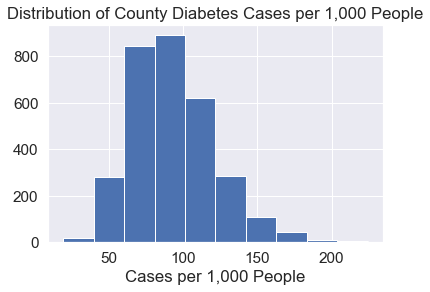

In [93]:
# diabetes per 100 people
#sns.histplot(data = diabetes, x = 'diabetes_per100', kde = True)
plt.hist(diabetes["diabetes_per1000"])
plt.title("Distribution of County Diabetes Cases per 1,000 People")
plt.xlabel("Cases per 1,000 People");

**Diabetes and Level of Inactivity**

We suspect there might be a relationship between diabetes and level of inactivity. To explore this, we plot the linear regression line of physical inactivity on diabetes cases, at the county level. We report both numbers per 1000 people. The plot below also includes a scatter plot of the underlying data. There is a linear relationship between number of diabetes cases and number of people who are physically inactive. There is greater variation around the middle of the distribution. This implies that the number of inactive people might not be a good linear predictor for the number of diabetes cases in counties with cases around the middle of the distribution. 

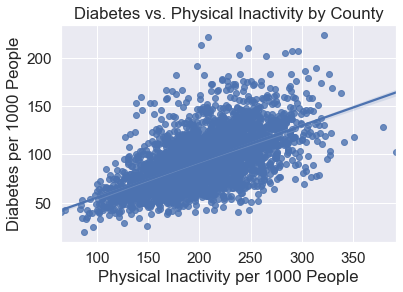

In [94]:
sns.regplot(data = diabetes, x ='physical_inactivity_per1000' , y = 'diabetes_per1000', scatter = True)
plt.title("Diabetes vs. Physical Inactivity by County")
plt.xlabel("Physical Inactivity per 1000 People")
plt.ylabel("Diabetes per 1000 People");

__Diabetes and obesity__

There is similarly a linear relationship between diabetes cases and the number of obese people at the county level. Again, this relationship seems weakest around the middle of the distribution, where there is greater variation, and it is not clear that increasing cases of obesity would predict increasing cases of diabetes. 

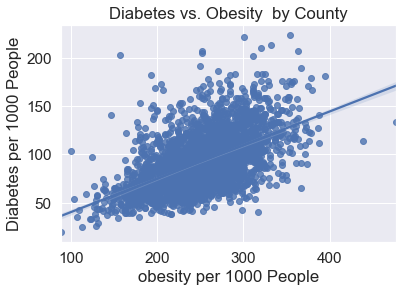

In [95]:
sns.regplot(data = diabetes, x ='obesity_per1000' , y ='diabetes_per1000' , scatter = True)
plt.title("Diabetes vs. Obesity  by County")
plt.xlabel("obesity per 1000 People")
plt.ylabel("Diabetes per 1000 People");

**Diabetes and Demographic Characteristics**

Our data contains county population counts by sex, race, and age (and interactions of all three). It is possible that upstream social factors that vary by gender, such as diet or activity levels, impact rates of diabetes. Although we do not observe the rates of diabetes differentially for men and women (the only genders reported in the ACS), we can see if counties with a higher male to female ratio have higher or lower rates of diabetes. For this, we create a dummy variable indicating if a county has more or equal number of women than men (female_cnty). We then plot a box-and-whisker diagram of cases per 100 people for the two types of county.

The plot below shows that for counties with equal or higher numbers of women than men, their rate of diabetes is slightly higher (orange plot). However, there is not a large difference and it may not be significant.  


In [96]:
# dummy for a county having more or equal number of women to men
diabetes['female_cnty'] = 1*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] <=100) \
+ 0*(diabetes['sex and age_total population_sex ratio (males per 100 females)'] > 100)
#diabetes['female_cnty']

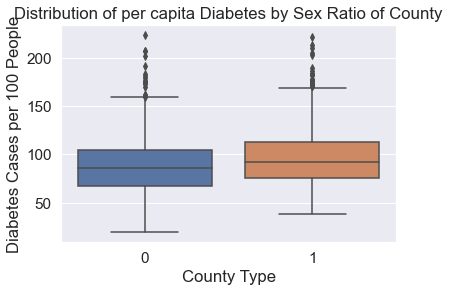

In [97]:
sns.boxplot(data = diabetes, x = 'female_cnty', y = 'diabetes_per1000')
plt.title('Distribution of per capita Diabetes by Sex Ratio of County')
plt.xlabel('County Type')
plt.ylabel('Diabetes Cases per 100 People');

## 3. Data perperation for machine learning models.

In this next section we prepare the data so we can use it to fir machine learning models. Our process includes additional data cleaning steps, data partition, and preliminary feature selection.

### 3.1 Feature Selection

We examine the correlation of the sociodemographic variables included in the sample and select only ones with low correltation with one another. Because much of the variables in regards to the racial composition and the sex distribution in the counties are related, not doing so will lead our models to not converge. Hence, driven both by prior literature/theory and the correlation of these variables in our dataset, we select obesity and physical activity counts per capita, the distribution of each broadly defined racial group (white, Black/African American, American Indian/Aaska Native, Native Hawaiian/Pacific Islander, and Hispanic/Latino), eligible voters, the sex ratio of the entire population, and total housing units in each county. Although limited, we believe these features will allow us to estimate the influence of historical and institutional practices that continue to disproportionately burden marginalized populations around the country, while using physical inactivity and obesity counts as a proxy to account for the availablility of health promoting resources. Total housing is potentially a proxy for wealth. 

There are various variables reporting counts of people by race. We use the "race alone or in combination with one or more other races", which includes in each category people who report one or more race. These categories sum together to the total population. We exclude the category "other race". We convert each of the race count variables to percentages, so that rather than capturing the count of people of a given race, we capture the distribution of people across different races. This controls for the fact that counties vary in population size. 

Q: should we have county population size as a predictor?

In [98]:
diabetes_clean = diabetes[[
                            'diabetes_per1000'
                           ,'physical_inactivity_per1000'
                           ,'obesity_per1000'
                           ,'sex and age_total population_65 years and over_sex ratio (males per 100 females)'
                           , 'race alone or in combination with one or more other races_total population'
                           , 'race alone or in combination with one or more other races_total population_white'
                           , 'race alone or in combination with one or more other races_total population_black or african american'
                           , 'race alone or in combination with one or more other races_total population_american indian and alaska native'
                           , 'race alone or in combination with one or more other races_total population_asian'
                           , 'race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander'
                           , 'race alone or in combination with one or more other races_total population_some other race'
                           , 'hispanic or latino and race_total population_hispanic or latino (of any race)'
                           , 'sex and age_total population_65 years and over_1'
                           , 'sex and age_total population_65 years and over_male'
                           , 'sex and age_total population_65 years and over_female'
                           , 'sex and age_total population', 'sex and age_total population_male'
                           , 'sex and age_total population_female'
                           , 'sex and age_total population_sex ratio (males per 100 females)'
                           , 'sex and age_total population_under 5 years'
                           , 'sex and age_total population_5 to 9 years'
                           , 'sex and age_total population_10 to 14 years'
                           , 'sex and age_total population_15 to 19 years'
                           , 'sex and age_total population_20 to 24 years'
                           , 'sex and age_total population_25 to 34 years'
                           , 'sex and age_total population_35 to 44 years'
                           , 'sex and age_total population_45 to 54 years'
                           , 'sex and age_total population_55 to 59 years'
                           , 'sex and age_total population_60 to 64 years'
                           , 'sex and age_total population_65 to 74 years'
                           , 'sex and age_total population_75 to 84 years'
                           , 'sex and age_total population_85 years and over'
                           , 'sex and age_total population_median age (years)'
                           , 'total housing units'
                           , 'citizen -  voting age population_citizen -  18 and over population' 
                          ]]
diabetes_clean.shape

(3112, 35)

### 3.2 Additional Data Cleaning and preparation

In [99]:
# convert count variables to percents
diabetes_clean.loc[:,'pct_white'] = diabetes_clean['race alone or in combination with one or more other races_total population_white']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_black'] = diabetes_clean['race alone or in combination with one or more other races_total population_black or african american']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_native'] = diabetes_clean['race alone or in combination with one or more other races_total population_american indian and alaska native']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_asian'] = diabetes_clean['race alone or in combination with one or more other races_total population_asian']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_pacisl'] = diabetes_clean['race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_other'] = diabetes_clean['race alone or in combination with one or more other races_total population_some other race']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_hispan'] = diabetes_clean['hispanic or latino and race_total population_hispanic or latino (of any race)']/diabetes_clean['race alone or in combination with one or more other races_total population']

diabetes_clean.loc[:,'pct_under5'] = diabetes_clean['sex and age_total population_under 5 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_5_to_9'] = diabetes_clean['sex and age_total population_5 to 9 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_10_to_14'] = diabetes_clean['sex and age_total population_10 to 14 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_15_to_19'] = diabetes_clean['sex and age_total population_15 to 19 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_20_to_24'] = diabetes_clean['sex and age_total population_20 to 24 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_25_to_34'] = diabetes_clean[ 'sex and age_total population_25 to 34 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_35_to_44'] = diabetes_clean[ 'sex and age_total population_35 to 44 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_45_to_54'] = diabetes_clean[ 'sex and age_total population_45 to 54 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_55_to_59'] = diabetes_clean['sex and age_total population_55 to 59 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_60_to_64'] = diabetes_clean[ 'sex and age_total population_60 to 64 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_65_to_74'] = diabetes_clean[ 'sex and age_total population_65 to 74 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_75_to_84'] = diabetes_clean[ 'sex and age_total population_75 to 84 years']/diabetes_clean['race alone or in combination with one or more other races_total population']
diabetes_clean.loc[:,'pct_85_over'] = diabetes_clean[ 'sex and age_total population_85 years and over']/diabetes_clean['race alone or in combination with one or more other races_total population']

diabetes_clean.loc[:,'pct_male'] = diabetes_clean['sex and age_total population_male']/diabetes_clean['sex and age_total population']
diabetes_clean.loc[:,'pct_female'] = diabetes_clean['sex and age_total population_female']/diabetes_clean['sex and age_total population']  
diabetes_clean.loc[:,'houses_per_capita'] = diabetes_clean['total housing units']/diabetes_clean['sex and age_total population']
diabetes_clean.loc[:,'citizens_per_capita'] = diabetes_clean['citizen -  voting age population_citizen -  18 and over population']/diabetes_clean['sex and age_total population']

diabetes_clean.head(3)

C:\Users\heroa\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\heroa\anaconda3\lib\site-packages\pandas\core\indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


,diabetes_per1000,physical_inactivity_per1000,obesity_per1000,sex and age_total population_65 years and over_sex ratio (males per 100 females),race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,...,pct_45_to_54,pct_55_to_59,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,pct_female,houses_per_capita,citizens_per_capita
0,93.804348,226.902174,244.365942,76.5,55200,43367,10962,464,895,115,...,0.142264,0.074837,0.048804,0.085344,0.045725,0.014764,0.486848,0.513152,0.422373,0.748261
1,80.280817,192.324141,233.255008,86.6,208107,182689,20311,3185,2824,79,...,0.136132,0.069387,0.071362,0.117973,0.058456,0.018976,0.486231,0.513769,0.537920,0.764957
2,131.874952,210.650842,310.643084,76.2,25782,12461,12492,301,155,1,...,0.133892,0.064270,0.064037,0.109379,0.053991,0.016368,0.531262,0.468738,0.462997,0.775386


Preparation for logistic regression: We create a binary variable for high diabetes cases indicator based on median split and separating the response from the features:

In [100]:
# create a binary variable for logistic regression
diabetes_clean.describe() #median of Diabetes counts is 89.29 [high diabetes: >89.29 and low diabetes <=89.29]
diabetes_clean.loc[diabetes_clean['diabetes_per1000'] < 89.29, 'diabetes_cat'] = "< 89.29"
diabetes_clean.loc[diabetes_clean['diabetes_per1000'] >= 89.29, 'diabetes_cat'] = ">= 89.29"

from sklearn.preprocessing import LabelBinarizer

lb_style = LabelBinarizer()
diabetes_clean.loc[:,'diabetes_binary'] = lb_style.fit_transform(diabetes_clean.loc[:,"diabetes_cat"])
diabetes_clean.head(3)

C:\Users\heroa\anaconda3\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\heroa\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
C:\Users\heroa\anaconda3\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

,diabetes_per1000,physical_inactivity_per1000,obesity_per1000,sex and age_total population_65 years and over_sex ratio (males per 100 females),race alone or in combination with one or more other races_total population,race alone or in combination with one or more other races_total population_white,race alone or in combination with one or more other races_total population_black or african american,race alone or in combination with one or more other races_total population_american indian and alaska native,race alone or in combination with one or more other races_total population_asian,race alone or in combination with one or more other races_total population_native hawaiian and other pacific islander,...,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,pct_female,houses_per_capita,citizens_per_capita,diabetes_cat,diabetes_binary
0,93.804348,226.902174,244.365942,76.5,55200,43367,10962,464,895,115,...,0.048804,0.085344,0.045725,0.014764,0.486848,0.513152,0.422373,0.748261,>= 89.29,1
1,80.280817,192.324141,233.255008,86.6,208107,182689,20311,3185,2824,79,...,0.071362,0.117973,0.058456,0.018976,0.486231,0.513769,0.537920,0.764957,< 89.29,0
2,131.874952,210.650842,310.643084,76.2,25782,12461,12492,301,155,1,...,0.064037,0.109379,0.053991,0.016368,0.531262,0.468738,0.462997,0.775386,>= 89.29,1


In [101]:
# We create a final clean dataset with all the features renamed and set as a rate/percentage to account for population size.
diabetes_clean2 = diabetes_clean[['diabetes_per1000',
                                 'physical_inactivity_per1000',
                                 'obesity_per1000','diabetes_binary',
                                 'pct_white',
                                 'pct_black',
                                 'pct_native',
                                 'pct_asian',
                                 'pct_pacisl',
                                 'pct_other',
                                 'pct_hispan',
                                 'pct_under5',
                                 'pct_5_to_9',
                                 'pct_10_to_14',
                                 'pct_15_to_19',
                                 'pct_20_to_24',
                                 'pct_25_to_34',
                                 'pct_35_to_44',
                                 'pct_45_to_54',
                                 'pct_55_to_59',
                                 'pct_60_to_64',
                                 'pct_65_to_74',
                                 'pct_75_to_84',
                                 'pct_85_over',
                                 'pct_male',
                                 'pct_female',
                                 'houses_per_capita',
                                 'citizens_per_capita']]
diabetes_clean2.head()

,diabetes_per1000,physical_inactivity_per1000,obesity_per1000,diabetes_binary,pct_white,pct_black,pct_native,pct_asian,pct_pacisl,pct_other,...,pct_45_to_54,pct_55_to_59,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,pct_female,houses_per_capita,citizens_per_capita
0,93.804348,226.902174,244.365942,1,0.785634,0.198587,0.008406,0.016214,0.002083,0.007736,...,0.142264,0.074837,0.048804,0.085344,0.045725,0.014764,0.486848,0.513152,0.422373,0.748261
1,80.280817,192.324141,233.255008,0,0.877861,0.097599,0.015305,0.013570,0.000380,0.012724,...,0.136132,0.069387,0.071362,0.117973,0.058456,0.018976,0.486231,0.513769,0.537920,0.764957
2,131.874952,210.650842,310.643084,1,0.483322,0.484524,0.011675,0.006012,0.000039,0.031029,...,0.133892,0.064270,0.064037,0.109379,0.053991,0.016368,0.531262,0.468738,0.462997,0.775386
3,105.251476,258.667377,290.051938,1,0.774493,0.227150,0.003995,0.002264,0.000000,0.000400,...,0.152661,0.066320,0.053980,0.094198,0.049363,0.018955,0.539442,0.460558,0.406668,0.784481
4,108.977361,249.197675,246.803712,1,0.971134,0.019499,0.012386,0.005065,0.000919,0.008309,...,0.137861,0.067569,0.062677,0.106375,0.056119,0.015023,0.493260,0.506740,0.420193,0.739474


In [102]:
#pd.set_option('display.max_rows', None)
#diabetes_clean.corr()
#diabetes_clean.corr()['race_total population']
#diabetes_clean.corr()['total housing units']
#diabetes_clean.corr()['race alone or in combination with one or more other races_total population_white']
#diabetes_clean.corr()['race_total population_one race_white']
#diabetes_clean.corr()['race_total population_one race_black or african american']
#diabetes_clean.corr()['race_total population_one race_american indian and alaska native']
#diabetes_clean.corr()['race_total population_one race_asian']
#diabetes_clean.corr()['citizen -  voting age population_citizen -  18 and over population']
#diabetes_clean.corr()['sex and age_total population_sex ratio (males per 100 females)]

### 3.3 Partition Data

First, we specify our features and outcomes.

In [103]:
# parse data 
X = diabetes_clean2.drop(['diabetes_per1000', 'diabetes_binary'], axis=1)
Y = diabetes_clean2['diabetes_per1000'] # for all other models
Y1 = diabetes_clean2['diabetes_binary'] # for logistic regression
X.head()

,physical_inactivity_per1000,obesity_per1000,pct_white,pct_black,pct_native,pct_asian,pct_pacisl,pct_other,pct_hispan,pct_under5,...,pct_45_to_54,pct_55_to_59,pct_60_to_64,pct_65_to_74,pct_75_to_84,pct_85_over,pct_male,pct_female,houses_per_capita,citizens_per_capita
0,226.902174,244.365942,0.785634,0.198587,0.008406,0.016214,0.002083,0.007736,0.027681,0.059112,...,0.142264,0.074837,0.048804,0.085344,0.045725,0.014764,0.486848,0.513152,0.422373,0.748261
1,192.324141,233.255008,0.877861,0.097599,0.015305,0.013570,0.000380,0.012724,0.044943,0.055784,...,0.136132,0.069387,0.071362,0.117973,0.058456,0.018976,0.486231,0.513769,0.537920,0.764957
2,210.650842,310.643084,0.483322,0.484524,0.011675,0.006012,0.000039,0.031029,0.042898,0.053914,...,0.133892,0.064270,0.064037,0.109379,0.053991,0.016368,0.531262,0.468738,0.462997,0.775386
3,258.667377,290.051938,0.774493,0.227150,0.003995,0.002264,0.000000,0.000400,0.024282,0.056599,...,0.152661,0.066320,0.053980,0.094198,0.049363,0.018955,0.539442,0.460558,0.406668,0.784481
4,249.197675,246.803712,0.971134,0.019499,0.012386,0.005065,0.000919,0.008309,0.091266,0.060456,...,0.137861,0.067569,0.062677,0.106375,0.056119,0.015023,0.493260,0.506740,0.420193,0.739474


#### Training Set

Since our dataset is small, we are interested in saving a relatively large portion (80%) of it for the training and validation sets, so that we can reduce overfitting. We also plan to fit validation models as well in order to tune the hyperparameters. The split out data 80:10:10 into training:validation:test data.

In [104]:
from sklearn.model_selection import train_test_split

# set the random seed to ensure that results are similar across different runs and machines. 
np.random.seed(10)

X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    train_size=0.80, test_size=0.20)
# for logistic regression splitting the data 4 ways
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y1,
                                                    train_size=0.80, test_size=0.20)

print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_test is", X_test.shape)
print("Shape of y_test is", y_test.shape)
print("Shape of y_train1 is", y_train.shape)
print("Shape of y_test1 is", y_test.shape)

Shape of X train is (2489, 26)
Shape of y_train is (2489,)
Shape of X_test is (623, 26)
Shape of y_test is (623,)
Shape of y_train1 is (2489,)
Shape of y_test1 is (623,)


#### Validation Set

In order to tune our hyperparamters, we also set aside a validation data set from the training data. We subset 75% of our training data as validaton data. This gives a total split of training:validation:test as 60:20:20. 

In [105]:
X_train, X_validate, y_train, y_validate = train_test_split(X_train, y_train,
                                                    train_size=0.75, test_size=0.25)

# validation set for logistic regression
X_train1, X_validate1, y_train1, y_validate1 = train_test_split(X_train1, y_train1,
                                                    train_size=0.75, test_size=0.25)

print("Shape of X train is", X_train.shape)
print("Shape of y_train is", y_train.shape)
print("Shape of X_validate is", X_validate.shape)
print("Shape of y_validate is", y_validate.shape)
print("Shape of y_train is", y_train1.shape)
print("Shape of y_validate is", y_validate1.shape)

Shape of X train is (1866, 26)
Shape of y_train is (1866,)
Shape of X_validate is (623, 26)
Shape of y_validate is (623,)
Shape of y_train is (1866,)
Shape of y_validate is (623,)


## 4. Train Models

### 4.1 Model Descriptions

#### OLS: Linear regression
Basic logic and assumptions underlying the model: Ordinary Least Squares regression works to predict an outcome variable based on one or more treatment variables, using training data to estimate coefficients for the model. It assumes a linear relationship between the treatment variables and the outcome variable. OLS fits coefficients using values that minimize the sum of the squared errors, the distance from the predicted outcomes to the actual outcomes. 
 
Pros: OLS is straightforward and easy to interpret (when there are a reasonable number of predictors). It isn’t dependent on the scale of its predictors.
 
Cons: OLS assumes a linear relationship between X and Y, not allowing for much flexibility in the model. It is prone to overfitting (and does not account for the number of variables used), and can run into issues if input variables are correlated. While it provides unbiased estimates, this is at the cost of high variance in the test data. 
 
Why it works for this problem: OLS regression works well for predicting continuous and numeric variables that have a linear relationship. Our problem involves continuous numeric variables, which allows us to use OLS. As it assumes linear relationships, it may not end up being the best fit (we dropped two of our predictors that were linearly related to our outcome as they were highly correlated with our other predictors). That being said, it can serve as a useful comparison point for our other models.
 
#### Logistic regression
Basic logic and assumptions underlying the model: Logistic regressions models the probability of Y being a certain binary outcome, given one or more input variables. Input variables are used to estimate coefficients that maximize a likelihood function.
 
Pros: Logistic regressions are simple and easy to understand and interpret (again, conditional on not having too many predictors).
 
Cons: Logistic regressions don’t perform well on non-linear data, or data with extraneous or correlated features. They may overfit when tasked with many features, and assume underlying linear relationships (between the logit of the outcome and each predictor), which means that it often is not the best method to use where complex relationships are involved. They are limited to binary outcomes.
 
Why it works for this problem: Logistic regression makes sense for binary classifications, which means that it isn’t a perfect fit for our problem. However, our problem can be framed in a binary way: whether or not a county has a high rate of diabetes, which allows us to use logistic regression but introduces judgment beforehand about what constitutes a “high” rate of diabetes.
 
#### Ridge
Basic logic and assumptions underlying the model: Ridge builds off of OLS by shrinking regression coefficients toward zero in order to penalize overfitting, using the sum of squared coefficients.
 
Pros: Reduction in variance from OLS (sometimes at the expense of an increase in bias). Ridge therefore works very well where there’s large variance.
 
Cons: Bias increases in the tradeoff made with a reduction in variance from OLS. Ridge is also easily affected by scale (we need to standardize coefficients to be of similar size). We can’t use it to do variable selection because it doesn’t shrink variables to be exactly zero.
 
Why it works for this problem: We can use Ridge for the same reasons that we can use OLS. Ridge often improves upon OLS, reducing variance, and depending on our data (if all predictor coefficients are of a similar size) it may be a better fit than Lasso. At this point, we don’t know which of the two would best fit our data.
 
#### Lasso
Basic logic and assumptions underlying the model: Similar to Ridge, Lasso shrinks regression coefficients toward zero by penalizing overfitting using the sum of the coefficients. Unlike Ridge, which uses all variables as predictors, Lasso can force some coefficient estimates to be exactly equal to zero, selecting only some variables to use as predictors.
 
Pros: Lasso is similar to Ridge, but produces simpler and more interpretable models. Lasso generally will perform better than Ridge where predictors are of very different sizes (in terms of bias and variance). It implicitly performs feature selection. 
 
Cons: Similar to OLS, Ridge, and Logistic regression, it is prone to overfitting and doesn’t handle extraneous or correlated features well. When there are many correlated features (predictors), it will keep only one but it’s choice of which one to keep is not clear. 
 
Why it works for this problem: Similar to Ridge, we are able to use Lasso to generate estimates that improve upon OLS by penalizing overfitting. Depending on our data, and the amount of variance in our predictors’ coefficient sizes,  it may be a better fit than Ridge. At this point, we don’t know which of the two would best fit our data.
 
#### Nearest neighbors regression
Basic logic and assumptions underlying the model: K-nearest neighbors makes predictions by identifying the observations in the dataset that are closest to the observation it is predicting, and assigning the new observation to the class that the majority of the most-similar observations (nearest neighbors) are in.
 
Pros: Nearest neighbors is simple and doesn’t assume relationships between variables (such as linear relationships assumed by the other models described).
 
Cons: Nearest neighbors is sensitive to outliers, and needs to use scaled data. It also can be difficult and slow with large datasets or those with many features. It doesn’t describe what predictors are most important – we don’t get information about coefficients or the like - so functions more as a black box.
 
Why it works for this problem: Nearest neighbors works for classification problems, and works best when there aren’t too many features, which is the case for our dataset. The fact that it does not assume any relationships between our variables makes it quite appealing.




### 4.2 Train Models
1. Linear Regression
2. Logistic Regression
3. Ridge Regression
4. Lasso
5. Nearest neighbors

Below, we train each model on the training set and predict our outcome on the validation set. We then assess how well our models fit the train data by reporting accuracy scores. Documentation: https://scikit-learn.org/stable/modules/model_evaluation.html

We ran into some issues with logistic regression not converging and the OLS coefficients being very large in magnitude due to different scales of the variables. We therefore scaled all our variables to be mean zero and unit standard deviation. This is a necessary prior step when running Ridge and Lasso too.  

#### Process steps for each ML method:

We want to see how well each model fits the data. Using the training data, we fit each model and predict the response variable.  We calculate the mean squared error to understand how well the model fits the training data, and that will help us compare models. 

In [106]:
# We define a function to estimate the Root-Mean-Square-Deviation for all models.
def rmse(pred, actual):
    return np.sqrt(np.mean((pred - actual) ** 2))

#### 1. OLS

We start by running OLS.

In [107]:
# 1.create a model
lin_reg = LinearRegression()

# 2.fit the model
lin_model = lin_reg.fit(X_train, y_train)

# look at the coefficients
print(lin_model.coef_)
print(lin_model.intercept_)

[   0.20239876    0.17411632  -55.578059     -9.53386935  -14.81214399
  -92.24347503  122.9663234   -49.77867771    9.95431984    6.79821174
 -136.68252951    9.06408854   64.04218691  -63.456923    -66.68322489
   83.54936289   59.35692696  -32.11552579  -95.99719448  161.65881192
  104.59227029  -94.12646157  -31.80933779   31.80933779   -5.27421057
   17.40938859]
34.726960954639765


We can visualize the coefficients. There are many coefficients with large magnitudes. As our data has not yet been normalized, it is hard to know if this means they are important or not.

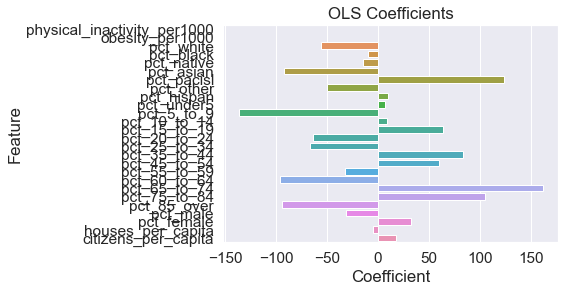

In [108]:
# 3. Plot coefficients 
# Create a dataframe with the coefficient and feature names
lin_reg_data = pd.DataFrame([lin_model.coef_, X.columns]).T
lin_reg_data.columns = ['Coefficient', 'Feature']
# Plot
ax = sns.barplot(data = lin_reg_data, y = 'Feature', x = 'Coefficient')
ax.set_title("OLS Coefficients")
plt.show()

We want to see how well this model fits our data. We predict our response variable from the training data and report the mean squared error, which will be used to compare this model with other models.

In [109]:
# 4. predict on the Training data
lin_pred = lin_model.predict(X_train)

# 5. calculate RMSE
rmse(lin_pred, y_train)

19.262891237638375

Below we tune the hyperparameters of the OLS model. We will then use they hyperparameters on the validation set in 5.1.

In [110]:
# 6. Tune Hyperparameters
param_grid = {'fit_intercept': ['True', 'False'],
              'normalize': ['True', 'False']}
lin_grid_reg = GridSearchCV(lin_reg, param_grid, cv=5, iid=False)
lin_grid_reg.fit(X_train, y_train)

best_lin_index = np.argmax(lin_grid_reg.cv_results_["mean_test_score"])

# print out the best hyperparameters
print(lin_grid_reg.cv_results_["params"][best_lin_index])

{'fit_intercept': 'True', 'normalize': 'True'}


C:\Users\heroa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


#### 2. Logistic Regression

In [111]:
# 1. create a model
log_reg = LogisticRegression()

# 2. fit the model
log_model = log_reg.fit(X_train1, y_train1)

print(log_model.coef_)
print(log_model.intercept_)

[[ 0.02422179  0.01603244 -1.91878106  0.6841635   0.35302634 -2.54542378
  -0.22336719 -0.0890887   0.5480768  -0.90973875 -1.01471474 -0.37269678
  -0.52296238 -1.15525598 -1.56817869 -0.88139506  0.05684749  0.23555717
   0.20804942  2.24629579  1.00108061 -0.21018736 -2.14327243 -0.74402682
   0.2318092   1.64437154]]
[-6.95302801]


C:\Users\heroa\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Examine the coefficients via visualization

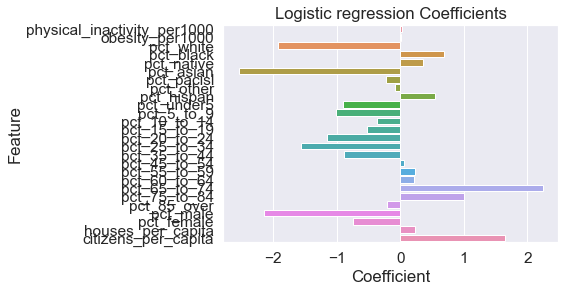

In [112]:
# 3. Plot Coefficients 
# Create a dataframe with the coefficient and feature names
log_reg_data = pd.DataFrame([log_model.coef_[0], X.columns]).T
log_reg_data.columns= ['Coefficient', 'Feature']
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=log_reg_data)
ax.set_title("Logistic regression Coefficients")
plt.show()

In [113]:
# 4. Predict on the training data
log_pred = log_model.predict(X_train1)

# 5. Calculate RMSE
rmse(log_pred, y_train1)

0.4805989475006082

Below we tune the hyperparameters of the Logistic Regression model

In [114]:
# 6. Tune Hyperparameters
param_grid = {'fit_intercept': [True, False],
             'max_iter': [1000]}
log_grid_reg = GridSearchCV(log_reg, param_grid, cv=3, iid=False)
log_grid_reg.fit(X_train1, y_train1)

# print out the best hyperparameters
best_log_index = np.argmax(log_grid_reg.cv_results_["mean_test_score"])
print(log_grid_reg.cv_results_["params"][best_log_index])

{'fit_intercept': False, 'max_iter': 1000}


C:\Users\heroa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


#### 3. Ridge Regression

In [115]:
# 1.create a model
ridge_reg = Ridge()

# 2.fit the model
ridge_model = ridge_reg.fit(X_train, y_train)

Visualize coefficients 

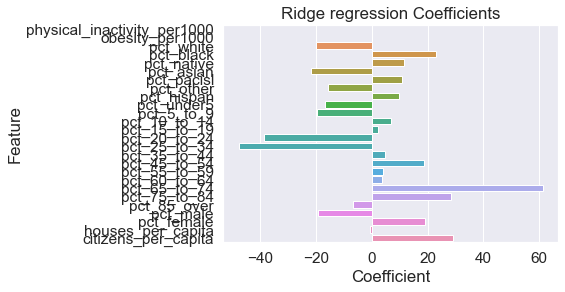

In [116]:
# 3. Plot coefficients
ridge_reg_data = pd.DataFrame([ridge_model.coef_, X.columns]).T
ridge_reg_data.columns = ['Coefficient', 'Feature']
ridge_reg_data.head()
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=ridge_reg_data)
ax.set_title("Ridge regression Coefficients")
plt.show()

In [117]:
# 4.predict on the training data
ridge_pred = ridge_model.predict(X_train)

#5.calculate rmse
print("Ridge RMSE: ",rmse(ridge_pred, y_train))

Ridge RMSE:  19.49197179782137


Next we tune the Ridge hyperparameters.

In [118]:
# 6. Tune Hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'solver': ['auto', 'svd', 'cholesky', 'lsqr']}

ridge_grid_reg = GridSearchCV(ridge_reg, param_grid, cv=3, iid=False)
ridge_grid_reg.fit(X_train, y_train)

best_ridge_index = np.argmax(ridge_grid_reg.cv_results_["mean_test_score"])

print(ridge_grid_reg.cv_results_["params"][best_ridge_index])

{'alpha': 0.1, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'auto'}


C:\Users\heroa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


#### 4. Lasso

In [119]:
# 1.create a model
lasso_reg = Lasso(max_iter=10000,alpha=0.05)

# 2.fit the model
lasso_model = lasso_reg.fit(X_train, y_train)

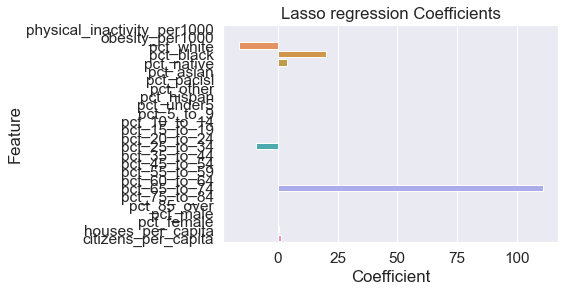

In [120]:
# 3. Plot coefficients
lasso_reg_data = pd.DataFrame([lasso_model.coef_, X.columns]).T
lasso_reg_data.columns = ['Coefficient', 'Feature']
lasso_reg_data.head()
# Plot
ax = sns.barplot(x="Coefficient", y="Feature", data=lasso_reg_data)
ax.set_title("Lasso regression Coefficients")
plt.show()

In [121]:
# 4.predict on the training data
lasso_pred = lasso_model.predict(X_train)

#5.calculate rmse
print("LASSO RMSE: ",rmse(lasso_pred, y_train))

LASSO RMSE:  19.73496375369719


Next we tune the hyperparameters using the training set.

In [122]:
# 6. Tune Hyperparameters
param_grid = {'alpha': np.arange(.1, 1, .1),
               'normalize': ['True', 'False'],
             'fit_intercept': ['True', 'False'],
             'selection': ['cyclic', 'random']}

lasso_grid_reg = GridSearchCV(lasso_reg, param_grid, cv=3, iid=False)
lasso_grid_reg.fit(X_train, y_train)

best_lasso_index = np.argmax(lasso_grid_reg.cv_results_["mean_test_score"])

print(lasso_grid_reg.cv_results_["params"][best_lasso_index])

{'alpha': 0.1, 'fit_intercept': 'False', 'normalize': 'True', 'selection': 'random'}


C:\Users\heroa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


#### 5. K-Nearest neighbors

In [123]:
# 1.create a model
neigh_reg = KNeighborsRegressor(n_neighbors=5)

# 2.fit the model
neigh_model=neigh_reg.fit(X_train, y_train)

# 3.predict on the training data
neigh_pred = neigh_model.predict(X_train)

#5.calculate rmse
print("Nearest neighbors RMSE: ",rmse(neigh_pred, y_train))

Nearest neighbors RMSE:  18.637172447180735


Tune hyperparameters

In [124]:
# 6. Tune Hyperparameters
param_grid = {'weights': ['uniform', 'distance'], 
              'n_neighbors' : [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
              'algorithm': ['ball_tree', 'kd_tree', 'brute']}

neigh_grid_reg = GridSearchCV(neigh_reg, param_grid, cv=3, iid=False)
neigh_grid_reg.fit(X_train, y_train)

best_neigh_index = np.argmax(neigh_grid_reg.cv_results_["mean_test_score"])

print(neigh_grid_reg.cv_results_["params"][best_neigh_index])

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}


C:\Users\heroa\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


## 5. Validate and Refine Model

### 5.1 Predict on the Validation Set

For each of the models below, we take the best model tuned above on the training data, and use it to predict on the validation data. We then report the RMSE for the validation data and plot the actual vs. predicted results.

#### 1. OLS

In [125]:
# reminder of best hyperparameters 
print(lin_grid_reg.cv_results_["params"][best_lin_index])

# predict y on validation set
best_lin_pred = lin_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(lin_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lin_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lin_pred, y_validate))

{'fit_intercept': 'True', 'normalize': 'True'}
Best CV R^2: 0.4926976536133919
Validation R^2: 0.45079611933089514
Validation RMSE 21.804571989772022


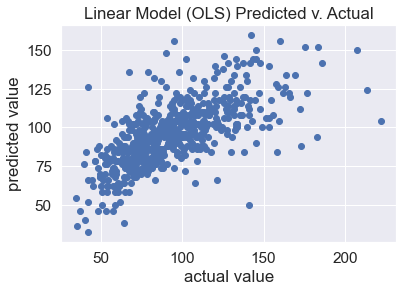

In [126]:
# plot the fit for the validation set
plt.scatter(y = best_lin_pred, x = y_validate)
plt.title('Linear Model (OLS) Predicted v. Actual')
plt.xlabel('actual value')
plt.ylabel('predicted value')
plt.show()

#### 2. Logistic Regression

In [127]:
# print out best hyperparameters
print(log_grid_reg.cv_results_["params"][best_log_index])

# use to predict on validation set
best_log_pred = log_grid_reg.best_estimator_.predict(X_validate1)

print('Best CV R^2:', max(log_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', log_grid_reg.score(X_validate1, y_validate1))
print('Validation RMSE', rmse(best_log_pred, y_validate1))

{'fit_intercept': False, 'max_iter': 1000}
Best CV R^2: 0.767416934619507
Validation R^2: 0.723916532905297
Validation RMSE 0.5254364539073236


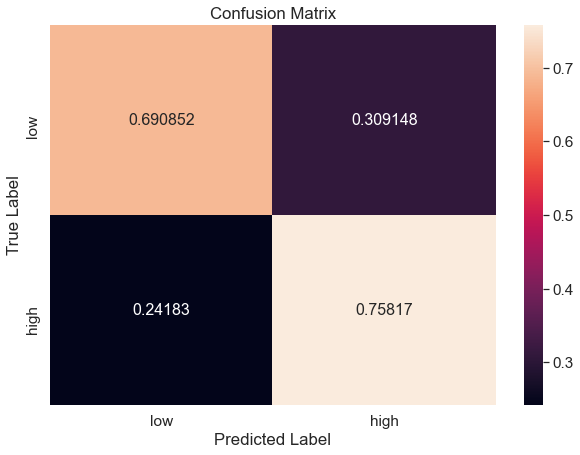

In [81]:
# show a confusion matrix 
cf_matrix = confusion_matrix(y_validate1, best_log_pred, normalize = "true")
df_cm = pd.DataFrame(cf_matrix, range(2),
                  range(2))

df_cm = df_cm.rename(index=str, columns={0: "low", 1: "high"})
df_cm.index = ["low", "high"]
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)#for label size
sns.heatmap(df_cm, 
           annot=True,
           annot_kws={"size": 16},
           fmt='g')

plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#plt.scatter(x = y_validate1, y = best_log_pred)
#plt.title('Logistic Regression Model')
#plt.xlabel('actual values')
#plt.ylabel('predicted values')
#plt.show()

#### 3. Ridge Regression

In [71]:
# print best hyperparameters 
print(ridge_grid_reg.cv_results_["params"][best_ridge_index])

# predict on the validation set 
best_ridge_pred = ridge_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', ridge_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_ridge_pred, y_validate))

{'alpha': 0.1, 'fit_intercept': 'True', 'normalize': 'True', 'solver': 'auto'}
Best CV R^2: 0.5059934598293457
Validation R^2: 0.45646295829059225
Validation RMSE 21.69178746940388


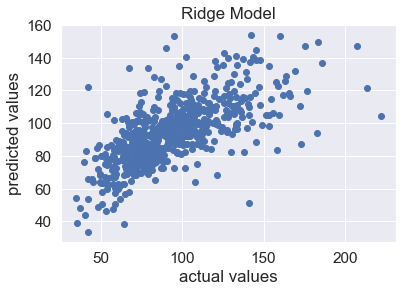

In [82]:
# plot the predictions
plt.scatter(x = y_validate, y = best_ridge_pred)
plt.title('Ridge Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 4. Lasso

In [73]:
# print the hyperparameters
print(lasso_grid_reg.cv_results_["params"][best_lasso_index])

# use to fit on validation data 
best_lasso_pred = lasso_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(lasso_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', lasso_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_lasso_pred, y_validate))

{'alpha': 0.1, 'fit_intercept': 'False', 'normalize': 'True', 'selection': 'random'}
Best CV R^2: 0.4488670231543363
Validation R^2: 0.3628619665873627
Validation RMSE 23.485376824560923


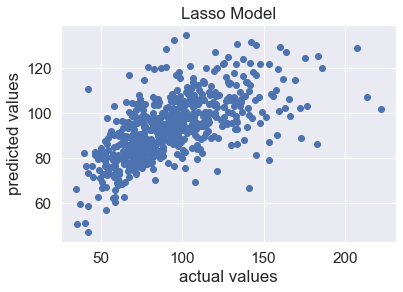

In [74]:
# plot the predictions
plt.scatter(x = y_validate, y = best_lasso_pred)
plt.title('Lasso Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

#### 5. K-Nearest neighbors

In [75]:
# print out the best hyperparameters:
print(neigh_grid_reg.cv_results_["params"][best_neigh_index])

# use to predict on the validation set:
best_neigh_pred = neigh_grid_reg.best_estimator_.predict(X_validate)

print('Best CV R^2:', max(neigh_grid_reg.cv_results_["mean_test_score"]))
print('Validation R^2:', neigh_grid_reg.score(X_validate, y_validate))
print('Validation RMSE', rmse(best_neigh_pred, y_validate))

{'algorithm': 'ball_tree', 'n_neighbors': 10, 'weights': 'uniform'}
Best CV R^2: 0.3854934694709878
Validation R^2: 0.3147884522255905
Validation RMSE 24.35527873533092


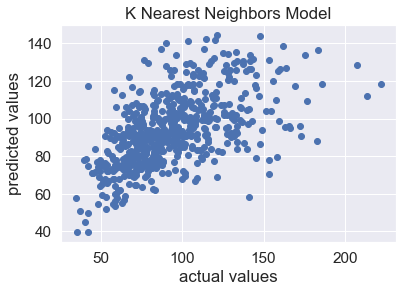

In [76]:
# plot the predictions
plt.scatter(x = y_validate, y = best_neigh_pred)
plt.title('K Nearest Neighbors Model')
plt.xlabel('actual values')
plt.ylabel('predicted values')
plt.show()

### 5.2 Feature Selection

In [117]:
# I will work on this tonight (saturday)

### 5.3 Evaluate performance of models on test set

To pick our best model, we compare the RMSE's of each of the model. As the logistic regression was run on a different target variable, we cannot easily compare this model to the other four. However, because we are more interested in predicting cases per capita, as opposed to a binary of below or above medium cases per capita, we disregard this model in our search for the best. The validation RMSE's of each model are printed below. While linear and ridge have very similar RMSEs, the ridge regression is slightly smaller. Additionally, ridge allows us to perform shrinkage, which is a desired feature (IS THIS RIGHT??). Therefore, we select ridge regression as our best performing model and use the hyperparameters tuned from the training data. 

In [77]:
print('Linear regression RMSE', rmse(best_lin_pred, y_validate))
print('Ridge regression RMSE', rmse(best_ridge_pred, y_validate))
print('LASSO regression RMSE', rmse(best_lasso_pred, y_validate))
print('k-Nearest Neighbor RMSE', rmse(best_neigh_pred, y_validate))


Linear regression RMSE 21.804571989772022
Ridge regression RMSE 21.69178746940388
LASSO regression RMSE 23.485376824560923
k-Nearest Neighbor RMSE 24.35527873533092


In [78]:
# Best model
best_pred = ridge_grid_reg.best_estimator_.predict(X_test)
print('Best CV R^2:', max(ridge_grid_reg.cv_results_["mean_test_score"]))
print('Test R^2:', ridge_grid_reg.score(X_test, y_test))
print('Test RMSE', rmse(best_pred, y_test))

Best CV R^2: 0.5059934598293457
Test R^2: 0.4596606123636515
Test RMSE 20.259508946973934


In [79]:
# make predictions for the test set using one model of your choice
final_pred = ridge_grid_reg.predict(X_test)
# calculate the rmse for the final predictions
print('Test set RMSE: ', rmse(final_pred, y_test))

Test set rmse:  20.259508946973934


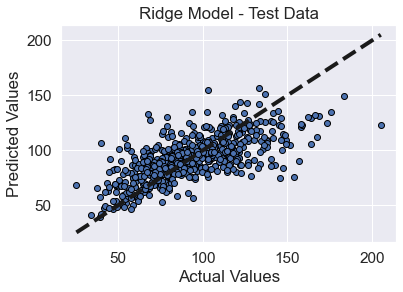

In [139]:
# show fit on the test set 
fig, ax = plt.subplots()
ax.scatter(y_test, final_pred, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.title('Ridge Model - Test Data')
plt.show()


**text in Google doc for explanation**

### 5.4 Implement Cross validation

We use ridge regression to refit our data using a k-fold validation approach. We first run it with the default hyperparameters and k = 5. This gives an RMSE slighlty above the RMSE for the best ridge model above. Similarly to the model above, it predicts well for counties per capita below 150. Above this, the predicted values are consistently lower than actualy values. 

In [137]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

ridge_crossval_pred = cross_val_predict(ridge_reg, X, Y, cv = 5)

print("Ridge cross-validation RMSE:", rmse(ridge_crossval_pred, Y))

Ridge cross-validation RMSE: 20.441046644696794


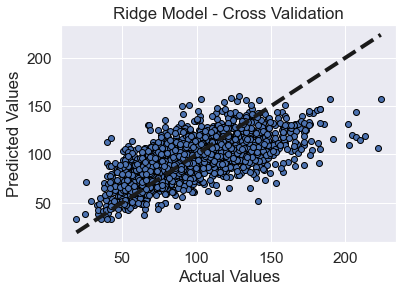

In [140]:
# show fit on the test set 
fig, ax = plt.subplots()
ax.scatter(Y, ridge_crossval_pred, edgecolors=(0, 0, 0))
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.title('Ridge Model - Cross Validation')
plt.show()

#### Different Ks
We experiment with different k-s...how?

## 6. Discussion Questions